In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext src

The src module is not an IPython extension.


In [3]:
import os
import sys
import rdkit.Chem as Chem
import openbabel as ob
import openbabel
import numpy as np
import datamol as dm
import torch
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from typing import Dict, List, Tuple, Union, Optional

from multiprocessing import Process, Queue, Pool


import openbabel as ob
from rdkit import Chem
from rdkit.Chem import AllChem

from src.utils.strain import *

# load data
from src.data.datasets import *
from src.utils.docking import SMINA
from src.utils.docking_utils import *

/home/cch57/micromamba/envs/poses/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cch57/projects/poses_benchmark/src/data/datasets.py:312: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.name is not "crossdocked_test":
/home/cch57/projects/poses_benchmark/src/data/datasets.py:318: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.name is not "crossdocked_test":
/home/cch57/micromamba/envs/poses/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [4]:
targetdiff_generated = DockedMolsDataset('crossdocked_test', docked=False)
graphbp_generated = GraphBPSamples()

In [18]:
diffsbdd = DiffSBDDSamples(False)

/home/cch57/projects/poses_benchmark/src/data/datasets.py:312: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.name is not "crossdocked_test":
/home/cch57/projects/poses_benchmark/src/data/datasets.py:318: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.name is not "crossdocked_test":


In [19]:
diffsbdd.ligand_dir

'/home/cch57/projects/poses_benchmark/data/benchmarks/diffsbdd/'

#### Test SMINA

In [18]:
smina = SMINA()

smina.set_receptor(receptor_path=targetdiff_generated.get_pdbqt_path(0))
smina.set_ligand_from_mol(targetdiff_generated.load_mols(0)[-1])

smina.score_pose()
smina.minimize_pose()
#smina.calculate_all()
smina.redock()

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/cch57/projects/poses_benchmark/src/data/../../data//crossdocked_pdbqt/2z3h-A-rec-1wn6-bst-lig-tt-docked-3-pocket10.pdbqt)



{'affinities': [-7.1, -7.1, -6.9, -6.8, -6.6, -6.4, -6.2, -6.1, -5.8],
 'mols': [<rdkit.Chem.rdchem.Mol at 0x2afcacdb1150>,
  <rdkit.Chem.rdchem.Mol at 0x2afcacdb29d0>]}

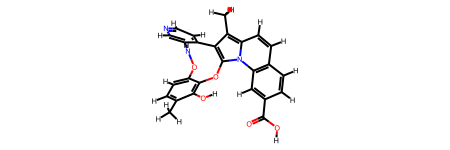

In [36]:
mols = targetdiff_generated.load_mols(10)
mol = mols[-1]

# init ring info
#mol = Chem.AddHs(mol)
Chem.GetSSSR(mol)  # SSSR: Smallest Set of Smallest Rings


relax_mol(mol)

In [57]:
from src.utils.docking import SMINA

def benchmark_mols_for_target(mols: List[Chem.Mol], receptor_path: str) -> Dict[str, Dict[str, float]]:
    """Benchmark a list of molecules for a target.
    
    Parameters
    ----------
    mols : list of rdkit.Chem.Mol
        The molecules to benchmark.
    target : str
        The target to benchmark against.
    
    Returns
    -------
    dict of str: dict of str: float
        A dictionary containing the results of the benchmark.
    """
    
    # Define the docking software and set the receptor
    smina = SMINA()
    smina.set_receptor(receptor_path)
        
    # Calculate the results for the raw molecules
    raw_results = [smina.calculate_all(mol) for mol in mols]
    
    # Calculate the results for the relaxed molecules
    relaxed_mols = [relax_mol(mol) for mol in mols]
    relaxed_results = [smina.calculate_all(mol) for mol in relaxed_mols]
    
    results = {'raw': raw_results, 'relaxed': relaxed_results, 'receptor_path': receptor_path}

    # Return the results
    return results

TARGET_IDX = 0
DATASET = targetdiff_generated

receptor_path = DATASET.get_pdbqt_path(TARGET_IDX)
mols = DATASET.load_mols(TARGET_IDX)

docking_results = benchmark_mols_for_target(mols, receptor_path)

torch.save(docking_results, f'docking_results_target_{TARGET_IDX}.pt')

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/cch57/projects/poses_benchmark/src/data/../../data//crossdocked_pdbqt/2z3h-A-rec-1wn6-bst-lig-tt-docked-3-pocket10.pdbqt)



## GraphBP

In [ ]:
pose_scores = [score['min_affinity'] for score in scores if score is not None]
pose_scores

In [ ]:
df = pd.DataFrame({'score': [score['affinity'] for score in scores if score is not None],
              'minimized': [score['min_affinity'] for score in minimized if score is not None],
              'redocked': [score['affinities'][0] for score in redocked if score is not None],
    })
df

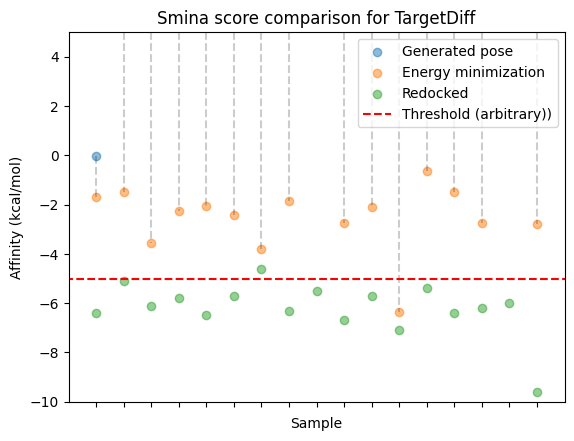

In [54]:
n_samples = len(df)

df.sort_values(by='score', inplace=True)

plt.scatter(range(n_samples), df['score'], alpha=0.5, label='Generated pose')
plt.scatter(range(n_samples), df['minimized'], alpha=0.5, label='Energy minimization')
plt.scatter(range(n_samples), df['redocked'], alpha=0.5, label='Redocked')

# plot lines between corresponding points
plt.vlines(range(n_samples), df['score'], df['minimized'], alpha=0.2, colors='k', linestyles='dashed')

plt.hlines(-5, -10, n_samples+10, alpha=1, colors='r', linestyles='dashed', label='Threshold (arbitrary))')

#plt.xscale('log')
plt.xlim(-1, n_samples)
plt.ylim(-10, 5)
plt.xticks(range(n_samples), '', rotation=90)
plt.xlabel('Sample')
plt.ylabel('Affinity (kcal/mol)')
plt.title('Smina score comparison for TargetDiff')
plt.legend()

## TargetDiff

In [11]:
smina.receptor

'/home/cch57/projects/poses_benchmark/src/data/../../data//crossdocked_pdbqt/2z3h-A-rec-1wn6-bst-lig-tt-docked-3-pocket10.pdbqt'

In [ ]:
smina = SMINA()

scores = []
minimized = []
redocked = []

relaxed_scores = []
relaxed_minimized = []
relaxed_redocked = []

names = []

for idx in tqdm(range(len(targetdiff_generated))):
    
    idx = 1
        
    pdbqt_file = targetdiff_generated.get_pdbqt_path(idx)
    #mols = targetdiff_generated.load_generated_mols(idx)
    name = targetdiff_generated.names[idx]
    
    mols = [mol['mol'] for mol in targetdiff_generated.data[idx]]
    pred_positions = [mol['pred_pos'] for mol in targetdiff_generated.data[idx]]
    mols = [update_coordinates(mol, pred_pos) for mol, pred_pos in zip(mols, pred_positions)]
    
    # Set receptor and ligand
    smina.set_receptor(pdbqt_file)
    
    # Dock mols
    for mol in mols[:20]:
        mol = Chem.AddHs(mol, addCoords=True)
        smina.set_ligand_from_mol(mol)
        
        score = smina.score_pose()
        minimize = smina.minimize_pose()
        redock = smina.redock()
        
        # Relax mol
        relaxed_mol = relax_mol(mol)
        smina.set_ligand_from_mol(relaxed_mol)
        
        relax_score = smina.score_pose()
        relax_minimize = smina.minimize_pose()
        relax_redock = smina.redock()
        
        scores.append(score)
        minimized.append(minimize)
        redocked.append(redock)
        
        relaxed_scores.append(relax_score)
        relaxed_minimized.append(relax_minimize)
        relaxed_redocked.append(relax_redock)
        
        names.append(name)
        
    break
        
    if idx == 2:
        break

In [19]:
df = pd.DataFrame({'generated': [score['affinity'] for score in scores],
                   'minimized': [score['min_affinity'] for score in minimized],
                   'redocked': [score['affinities'][0] for score in redocked],
                   'rmsd': [score['min_rmsd'] for score in minimized],
                   
                   'relaxed_generated': [score['affinity'] for score in relaxed_scores],
                    'relaxed_minimized': [score['min_affinity'] for score in relaxed_minimized],
                    'relaxed_redocked': [score['affinities'][0] for score in relaxed_redocked],
                   
                   
                   'generated_pose': [score['mol'] for score in scores],
                   'minimized_pose': [score['mol'] for score in minimized],
                   'name': [name[:4] for name in names]
                    })
df

,generated,minimized,redocked,rmsd,relaxed_generated,relaxed_minimized,relaxed_redocked,generated_pose,minimized_pose,name
0,-4.82157,-5.80347,-6.8,1.11654,0.0,0.0,-5.9,<rdkit.Chem.rdchem.Mol object at 0x2ba14fd63c30>,<rdkit.Chem.rdchem.Mol object at 0x2ba14fd63d10>,4aaw
1,-7.36600,-8.24150,-6.7,0.62654,0.0,0.0,-7.4,<rdkit.Chem.rdchem.Mol object at 0x2ba150b20e40>,<rdkit.Chem.rdchem.Mol object at 0x2ba150b23840>,4aaw
2,-5.21930,-5.80071,-7.0,1.11939,0.0,0.0,-6.8,<rdkit.Chem.rdchem.Mol object at 0x2ba150753370>,<rdkit.Chem.rdchem.Mol object at 0x2ba1507535a0>,4aaw
3,-4.93966,-5.61608,-6.0,0.62200,0.0,0.0,-6.0,<rdkit.Chem.rdchem.Mol object at 0x2ba1511226c0>,<rdkit.Chem.rdchem.Mol object at 0x2ba151123920>,4aaw
4,-5.88026,-7.68618,-6.9,0.52759,0.0,0.0,-8.4,<rdkit.Chem.rdchem.Mol object at 0x2ba151429930>,<rdkit.Chem.rdchem.Mol object at 0x2ba151429a80>,4aaw
5,-5.20402,-6.68443,-7.5,0.53328,0.0,0.0,-7.8,<rdkit.Chem.rdchem.Mol object at 0x2ba151429a10>,<rdkit.Chem.rdchem.Mol object at 0x2ba151429ee0>,4aaw
6,-6.54491,-8.01206,-8.9,0.86367,0.0,0.0,-7.5,<rdkit.Chem.rdchem.Mol object at 0x2ba1518c1b60>,<rdkit.Chem.rdchem.Mol object at 0x2ba1518c1700>,4aaw
7,-8.79644,-10.01871,-10.0,0.45851,0.0,0.0,-7.9,<rdkit.Chem.rdchem.Mol object at 0x2ba1518c1cb0>,<rdkit.Chem.rdchem.Mol object at 0x2ba1518c1380>,4aaw
8,-5.12318,-6.77677,-8.6,1.02504,0.0,0.0,-7.6,<rdkit.Chem.rdchem.Mol object at 0x2ba151fe2b20>,<rdkit.Chem.rdchem.Mol object at 0x2ba151fe2c70>,4aaw
9,-7.46785,-8.31263,-7.9,0.34478,0.0,0.0,-7.6,<rdkit.Chem.rdchem.Mol object at 0x2ba151fe25e0>,<rdkit.Chem.rdchem.Mol object at 0x2ba151fe2500>,4aaw


In [20]:
df.describe()

,generated,minimized,redocked,rmsd,relaxed_generated,relaxed_minimized,relaxed_redocked
count,17.000000,17.000000,17.000000,17.000000,17.0,17.0,17.000000
mean,-5.984626,-7.201262,-7.423529,0.747877,0.0,0.0,-7.141176
std,1.291172,1.237300,1.020741,0.482295,0.0,0.0,0.697369
min,-8.796440,-10.018710,-10.000000,0.230200,0.0,0.0,-8.400000
25%,-6.544910,-8.012060,-7.900000,0.491430,0.0,0.0,-7.600000
50%,-5.880260,-7.028060,-7.000000,0.622000,0.0,0.0,-7.400000
75%,-5.123180,-6.263160,-6.900000,0.863670,0.0,0.0,-6.700000
max,-3.951290,-5.472540,-6.000000,2.319810,0.0,0.0,-5.900000


(-10.0, 0.0)

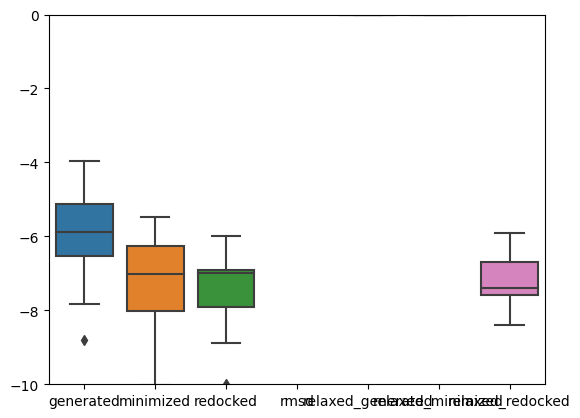

In [21]:
sns.boxplot(data=df)
plt.ylim(-10, 0)

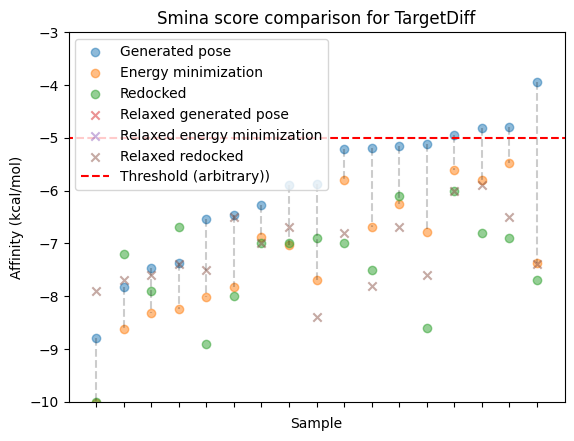

In [22]:
n_samples = len(df)

df.sort_values(by='generated', inplace=True)

plt.scatter(range(n_samples), df['generated'], alpha=0.5, label='Generated pose')
plt.scatter(range(n_samples), df['minimized'], alpha=0.5, label='Energy minimization')
plt.scatter(range(n_samples), df['redocked'], alpha=0.5, label='Redocked')

# relaxed
plt.scatter(range(n_samples), df['relaxed_generated'], alpha=0.5, label='Relaxed generated pose', marker='x')
plt.scatter(range(n_samples), df['relaxed_minimized'], alpha=0.5, label='Relaxed energy minimization', marker='x')
plt.scatter(range(n_samples), df['relaxed_redocked'], alpha=0.5, label='Relaxed redocked', marker='x')

# plot lines between corresponding points
plt.vlines(range(n_samples), df['generated'], df['minimized'], alpha=0.2, colors='k', linestyles='dashed')

plt.hlines(-5, -10, n_samples+10, alpha=1, colors='r', linestyles='dashed', label='Threshold (arbitrary))')

#plt.xscale('log')
plt.xlim(-1, n_samples)
plt.ylim(-10, -3)
plt.xticks(range(n_samples), '', rotation=90)
plt.xlabel('Sample')
plt.ylabel('Affinity (kcal/mol)')
plt.title('Smina score comparison for TargetDiff')
plt.legend()

/tmp/ipykernel_28160/1101676692.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.sort_values(by='generated', inplace=True)


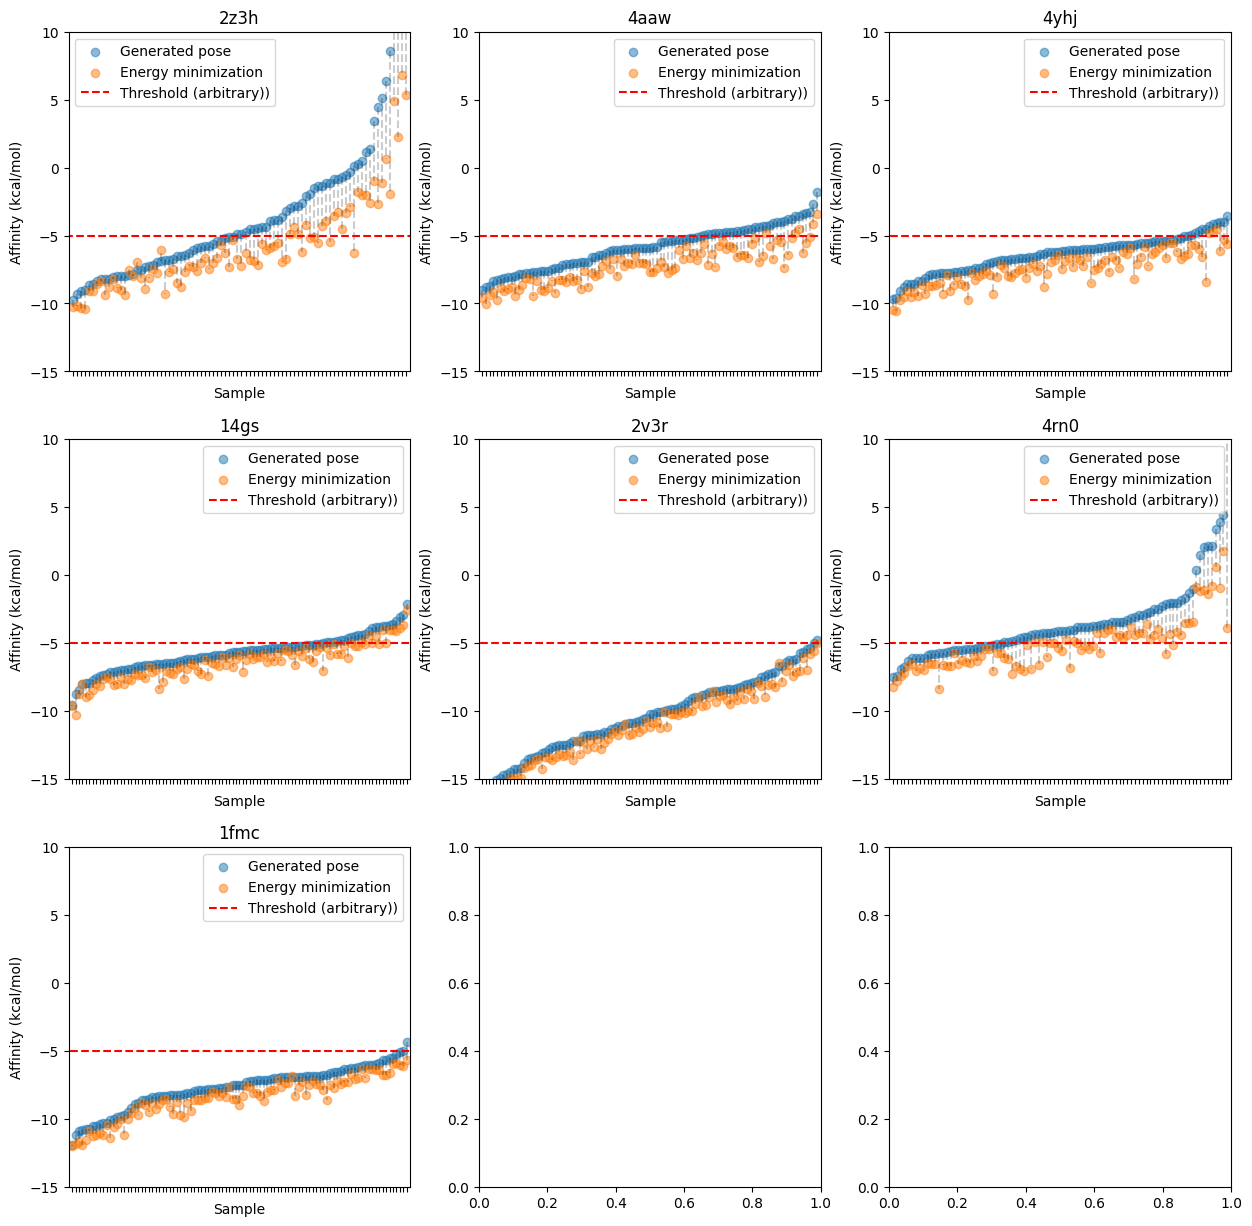

In [172]:
unique_names = df['name'].unique()

rows = len(unique_names) // 3 + 1

fig, axs = plt.subplots(rows, 3, figsize=(15, 5*rows))

for i, name in enumerate(unique_names):
    
    # get axes to plot on
    ax = axs[i // 3, i % 3]
    
    # select subset of data
    sub_df = df[df['name'] == name]
    n_samples = len(sub_df)

    sub_df.sort_values(by='generated', inplace=True)
    
    ax.scatter(range(n_samples), sub_df['generated'], alpha=0.5, label='Generated pose')
    ax.scatter(range(n_samples), sub_df['minimized'], alpha=0.5, label='Energy minimization')
    #ax.scatter(range(n_samples), sub_df['redocked'], alpha=0.5, label='Redocked')
    ax.vlines(range(n_samples), sub_df['generated'], sub_df['minimized'], alpha=0.2, colors='k', linestyles='dashed')
    
    ax.hlines(-5, -10, n_samples+10, alpha=1, colors='r', linestyles='dashed', label='Threshold (arbitrary))')
    
    ax.set_xlim(-1, n_samples)
    ax.set_ylim(-15, 10)
    ax.set_xticks(range(n_samples))
    ax.set_xticklabels('')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Affinity (kcal/mol)')
    ax.set_title(f'{name}')
    ax.legend()
    
plt.savefig('figures/affinity_comparison.png', bbox_inches='tight')

In [154]:
generated_poses = df.generated_pose.values
minimized_poses = df.minimized_pose.values

dm.to_sdf(generated_poses, "generated_poses.sdf")
dm.to_sdf(minimized_poses, "minimized_poses.sdf")